In [3]:
import sys
sys.path.append("../../helper")
from AnalysisHelper import helper

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

In [4]:
origin = read_excel("https://data.hossam.kr/E06/covid19_seoul_230531.xlsx")
origin

,서울시 기준일,서울시 확진자,서울시 추가 확진,서울시 치료중,서울시 퇴원,서울시 추가 퇴원,서울시 사망,서울시 의심환자 전체,서울시 의심환자 검사중,서울시 의심환자 검사결과(음성),...,전국 의심환자 전체,전국 의심환자 검사중,전국 의심환자 검사결과(음성),자가격리자 해외입국자 감시중,자가격리자 해외입국자 감시해제,자가격리자 접촉자 감시중,자가격리자 접촉자 감시해제,확인중 확진자,서울시 당일사망자,전국 당일 사망자
0,2023-05-31,6204277,5987.0,0,NaN,NaN,6492,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.0,17.0
1,2023-05-30,6198290,3326.0,0,NaN,NaN,6486,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,7.0
2,2023-05-29,6194964,1393.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0
3,2023-05-28,6194964,1393.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0
4,2023-05-27,6191196,4078.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,2020-02-09,10,0.0,10,0.0,0.0,0,459.0,45.0,414.0,...,2571.0,888.0,1683.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1208,2020-02-08,10,0.0,10,0.0,0.0,0,414.0,92.0,322.0,...,1677.0,620.0,1057.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1209,2020-02-07,10,0.0,10,0.0,0.0,0,322.0,115.0,207.0,...,1106.0,264.0,842.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1210,2020-02-06,11,0.0,11,0.0,0.0,0,192.0,28.0,164.0,...,591.0,169.0,693.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [5]:
df = origin.filter(['서울시 기준일', '서울시 추가 확진'])
df.rename(columns= {'서울시 기준일': 'date',
                                    '서울시 추가 확진': 'confirmed'}, inplace = True)
df.head()

,date,confirmed
0,2023-05-31,5987.0
1,2023-05-30,3326.0
2,2023-05-29,1393.0
3,2023-05-28,1393.0
4,2023-05-27,4078.0


In [6]:
df.dtypes

date          object
confirmed    float64
dtype: object

In [7]:
df['date'] = to_datetime(df['date'].str.strip(), format = "%Y-%m-%d")
df.dtypes

date         datetime64[ns]
confirmed           float64
dtype: object

In [8]:
df.isna().sum()

date         0
confirmed    1
dtype: int64

In [9]:
df2 = df.fillna(0)
df2.isna().sum()


date         0
confirmed    0
dtype: int64

In [10]:
df3 = helper.set_datetime_index(df2,'date')
df3.head()

,confirmed
2020-02-05,0.0
2020-02-06,0.0
2020-02-07,0.0
2020-02-08,0.0
2020-02-09,0.0


In [11]:
df3.tail()

,confirmed
2023-05-27,4078.0
2023-05-28,1393.0
2023-05-29,1393.0
2023-05-30,3326.0
2023-05-31,5987.0


#### 데이터 검정
이상치는 보이지만 데이터 자체가 실제 거래 데이터이므로 정상 데이터로 판단함.

결측치 수: 0


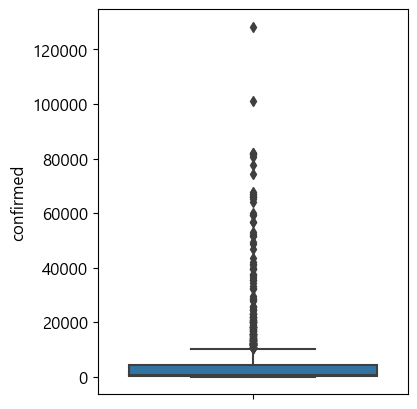

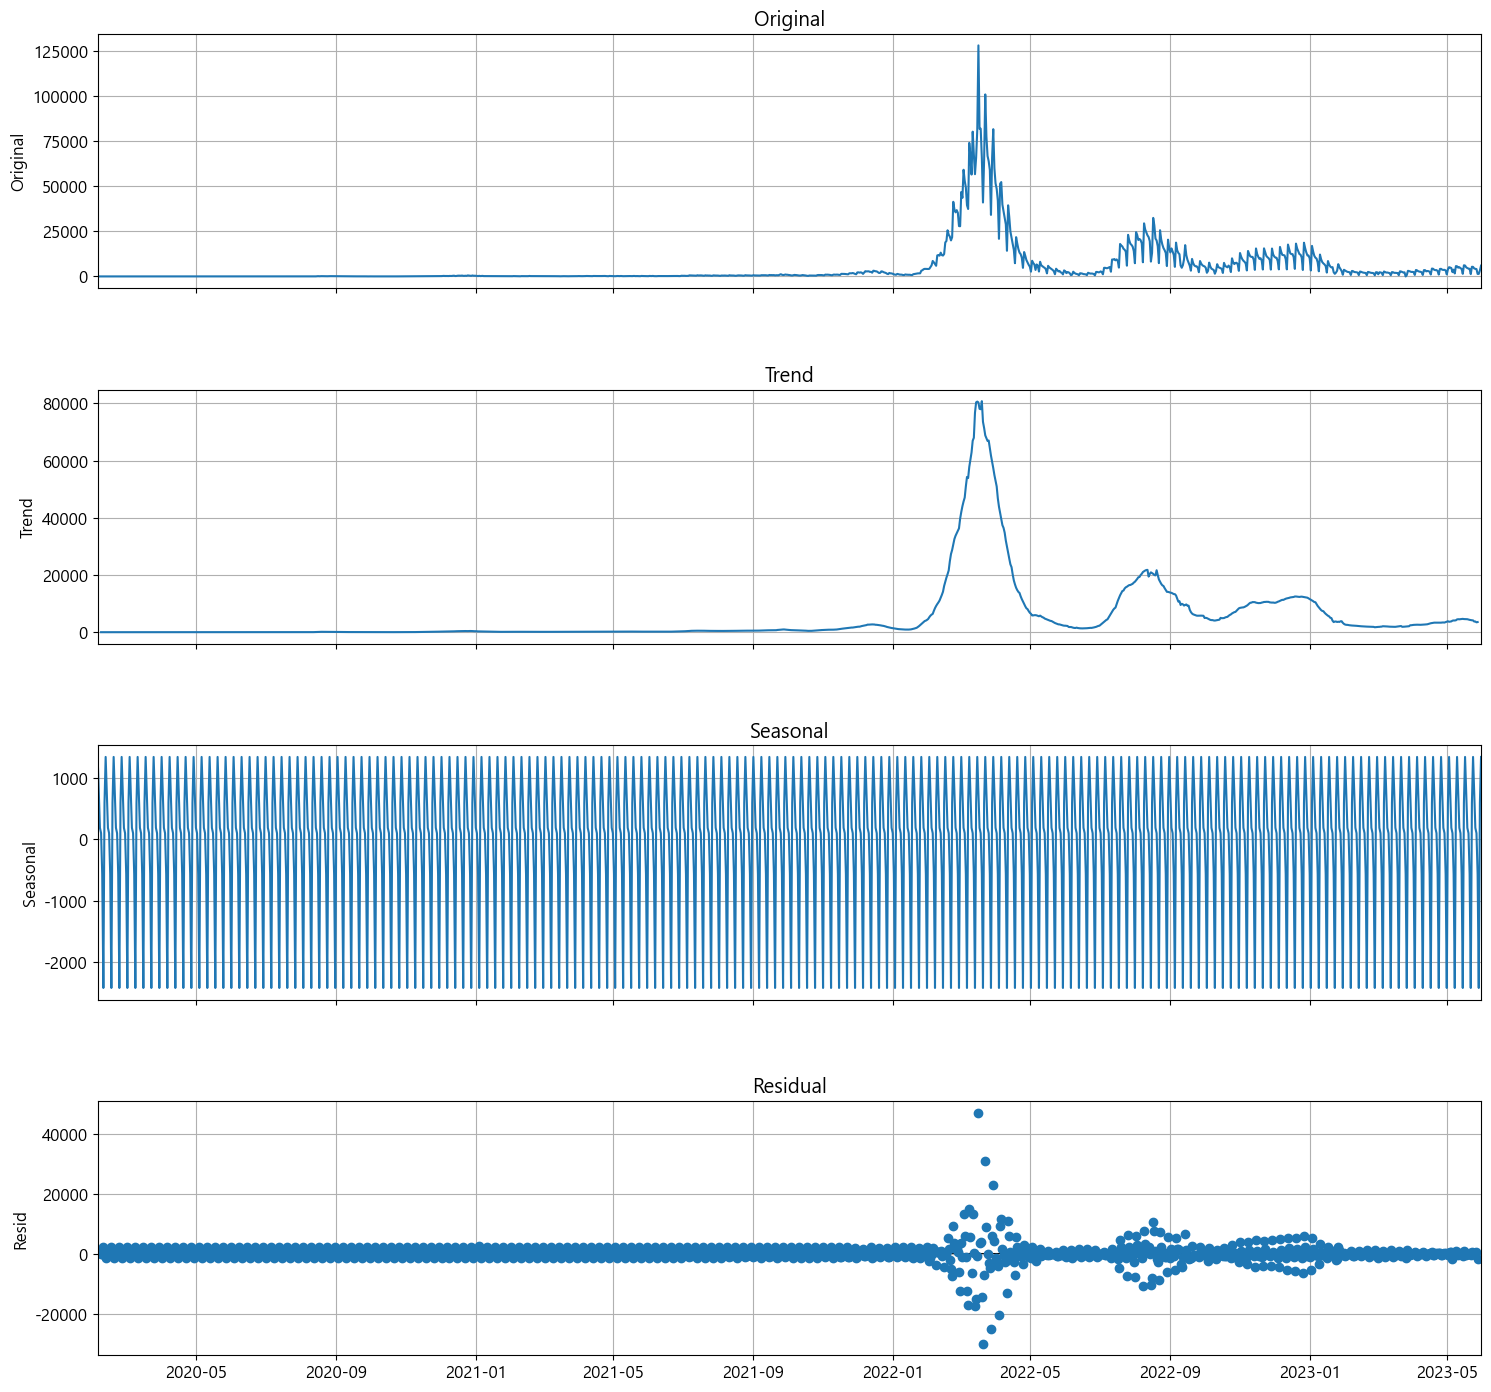

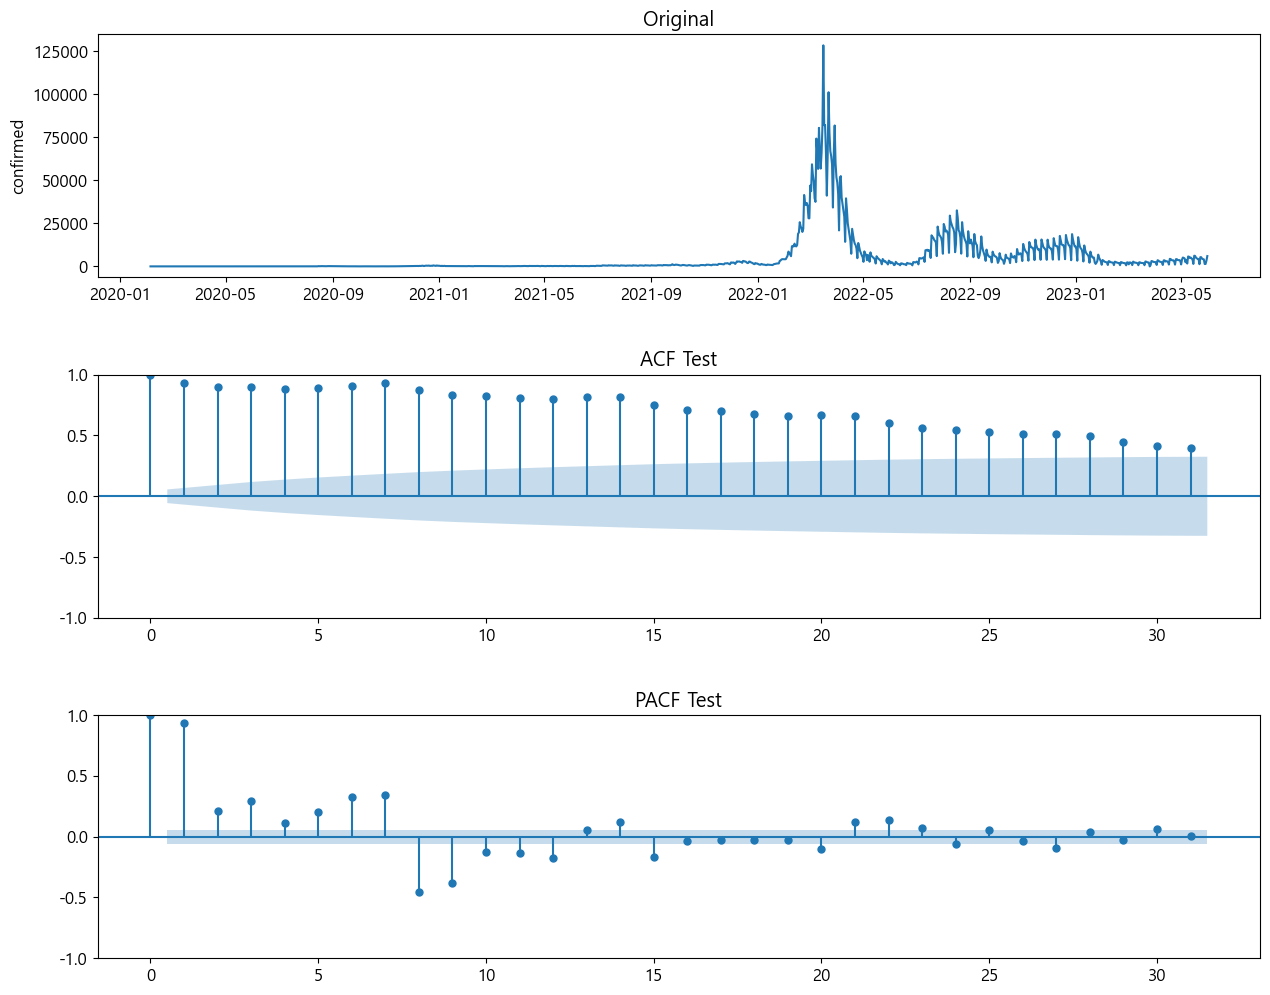

=========== 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -4.11626 |
| 유의수준(p-value)                  | 0.000910279 |
| 최적차수(num of lags)              |          23 |
| 관측치 개수(num of observations)   |        1188 |
| 기각값(Critical Values) 1%         |    -3.43587 |
| 기각값(Critical Values) 5%         |    -2.86398 |
| 기각값(Critical Values) 10%        |    -2.56807 |
| 데이터 정상성 여부(0=Flase,1=True) |           1 |
+------------------------------------+-------------+


In [12]:
helper.exp_time_data(data=df3, yname='confirmed', sd_model='a')

In [13]:
    model = ARIMA(df3['confirmed'], order=(1,0,0), seasonal_order=(1,0,0,7))
    fit = model.fit()
    print(fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                       confirmed   No. Observations:                 1212
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -11572.350
Date:                         Mon, 07 Aug 2023   AIC                          23152.700
Time:                                 11:18:41   BIC                          23173.100
Sample:                             02-05-2020   HQIC                         23160.381
                                  - 05-31-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5119.1137   2109.541      2.427      0.015     984.488    9253.739
ar.L1          0.7469      0.006    118.058      0.000     

#### 잔차 분석

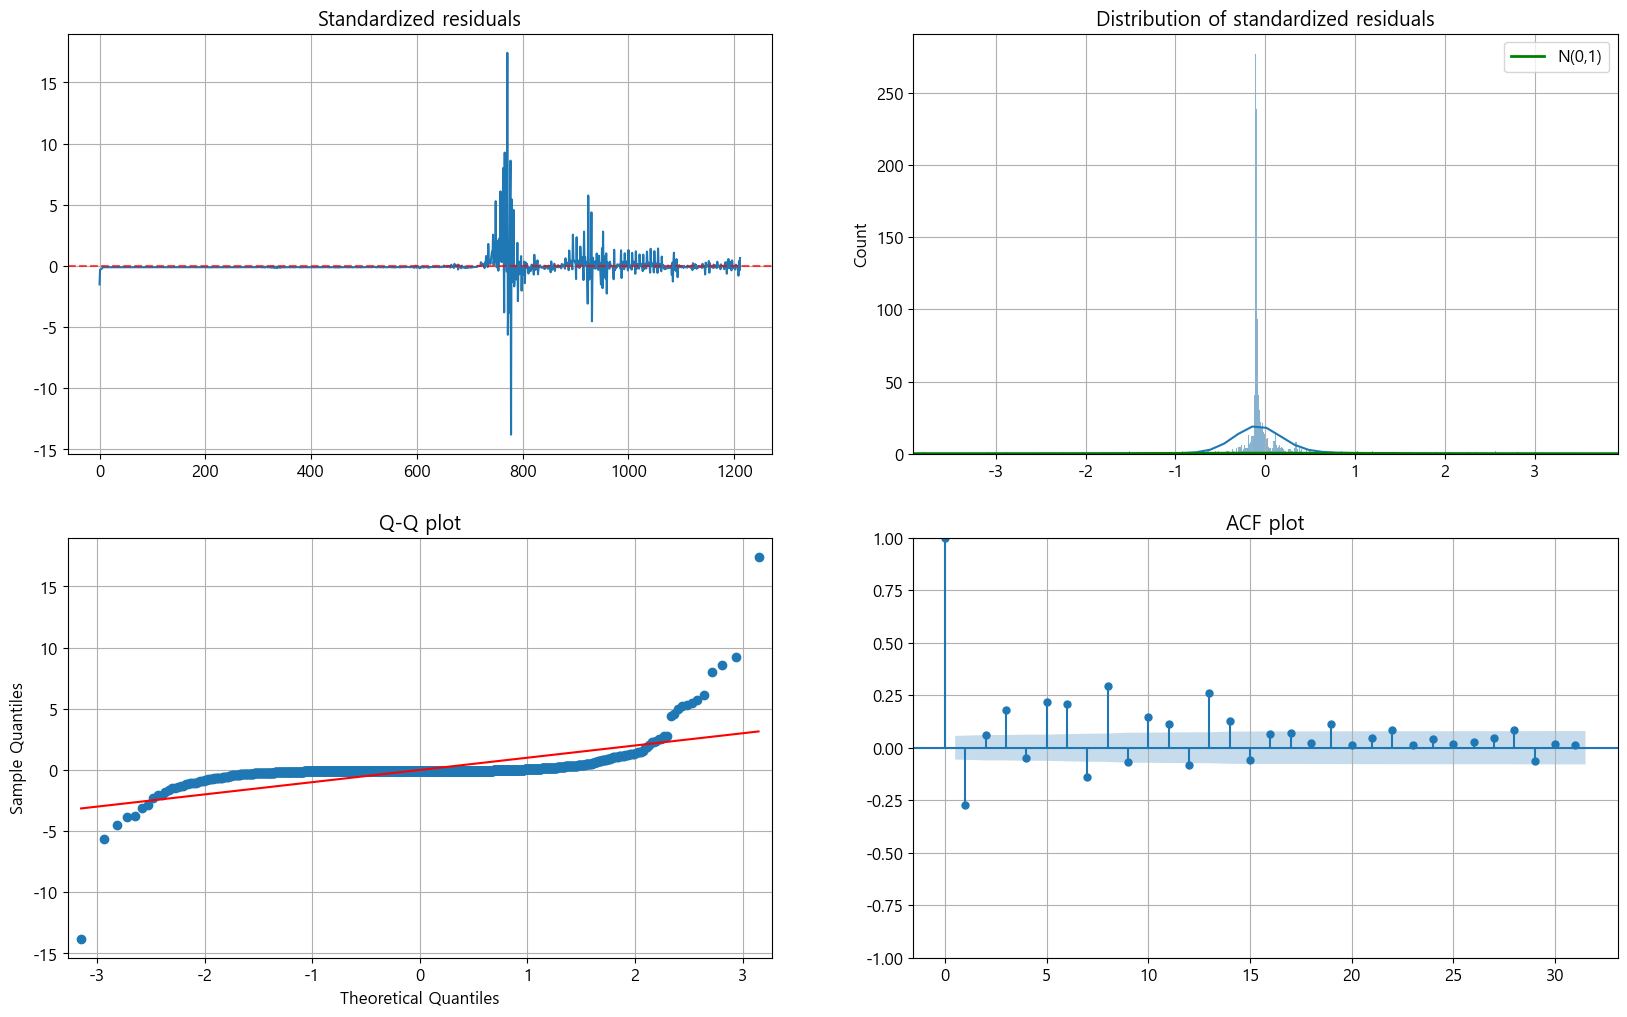

In [14]:
helper.arima_diagnostics(fit.resid)


In [15]:
fv = fit.fittedvalues
fv.head()

2020-02-05    5119.113665
2020-02-06    1037.069425
2020-02-07     959.246124
2020-02-08     861.651316
2020-02-09     741.551598
Freq: D, dtype: float64

In [16]:
fc = fit.forecast(30)
fc.head()


2023-06-01    5172.145643
2023-06-02    4877.622170
2023-06-03    4674.759816
2023-06-04    2668.118637
2023-06-05    2610.674361
Freq: D, Name: predicted_mean, dtype: float64

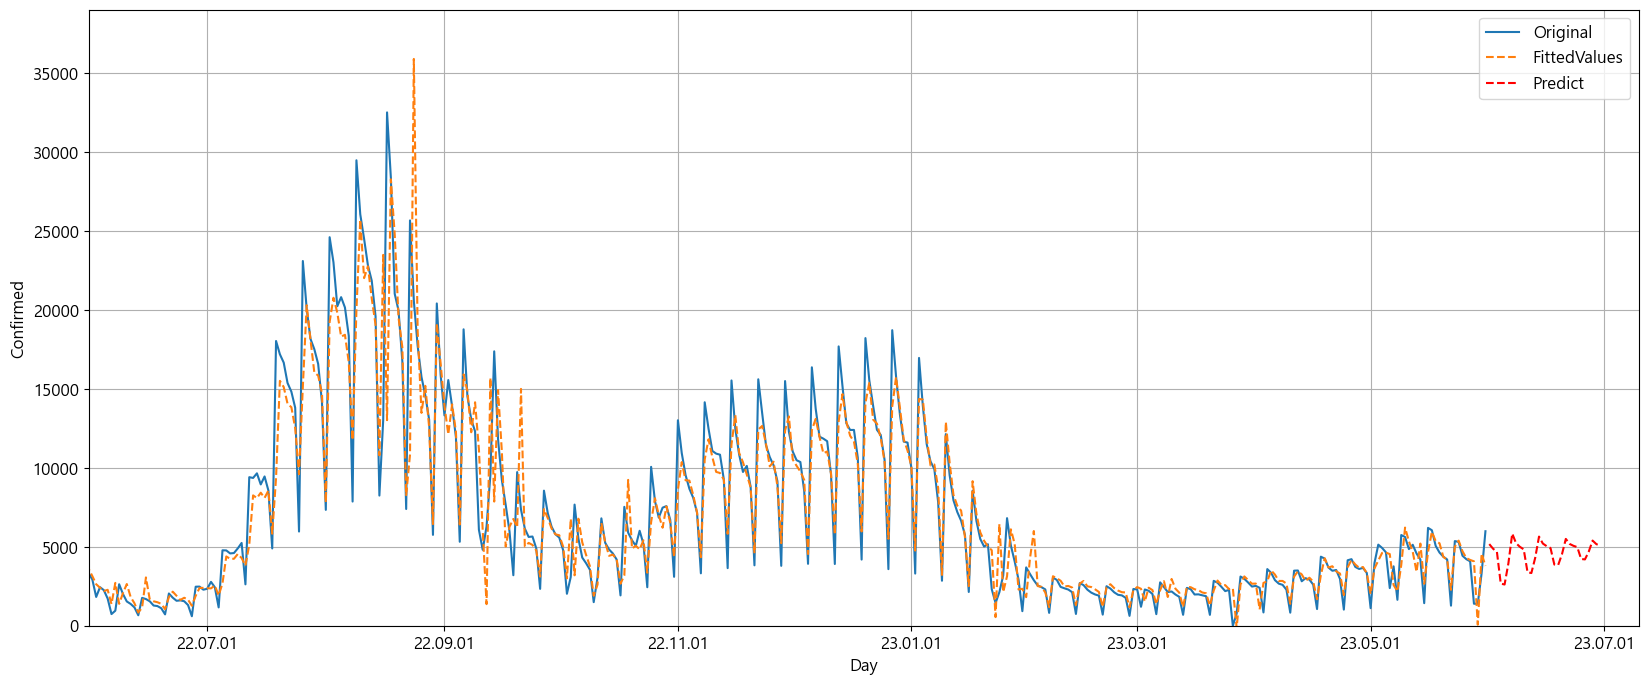

In [17]:
plt.figure(figsize=(20,8))

# 원본 데이터
sb.lineplot(data=df3, x=df3.index, y='confirmed', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 뒤 30% + 10단계에 대한 예측 데이터
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

last = df3.index.max()
xmin = last-timedelta(days=365)
xmax = last+timedelta(days=30+10)
ymax = df3['confirmed'][xmin:xmax].max()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()


In [18]:
my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 0    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 7    # 계절성 주기 (분석가가 판단)

model = auto_arima(
    y=df3['confirmed'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=26229.494, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=23152.696, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=26427.372, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=23752.801, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=23793.361, Time=0.79 sec
 ARIMA(1,0,0)(1,0,0)[7]             : AIC=23163.519, Time=0.31 sec

Best model:  ARIMA(1,0,0)(1,0,0)[7] intercept
Total fit time: 1.783 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1212
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -11572.348
Date:                           Mon, 07 Aug 2023   AIC                          23152.696
Time:                                   11:18:46   BIC                          23173.096
Sample:                     

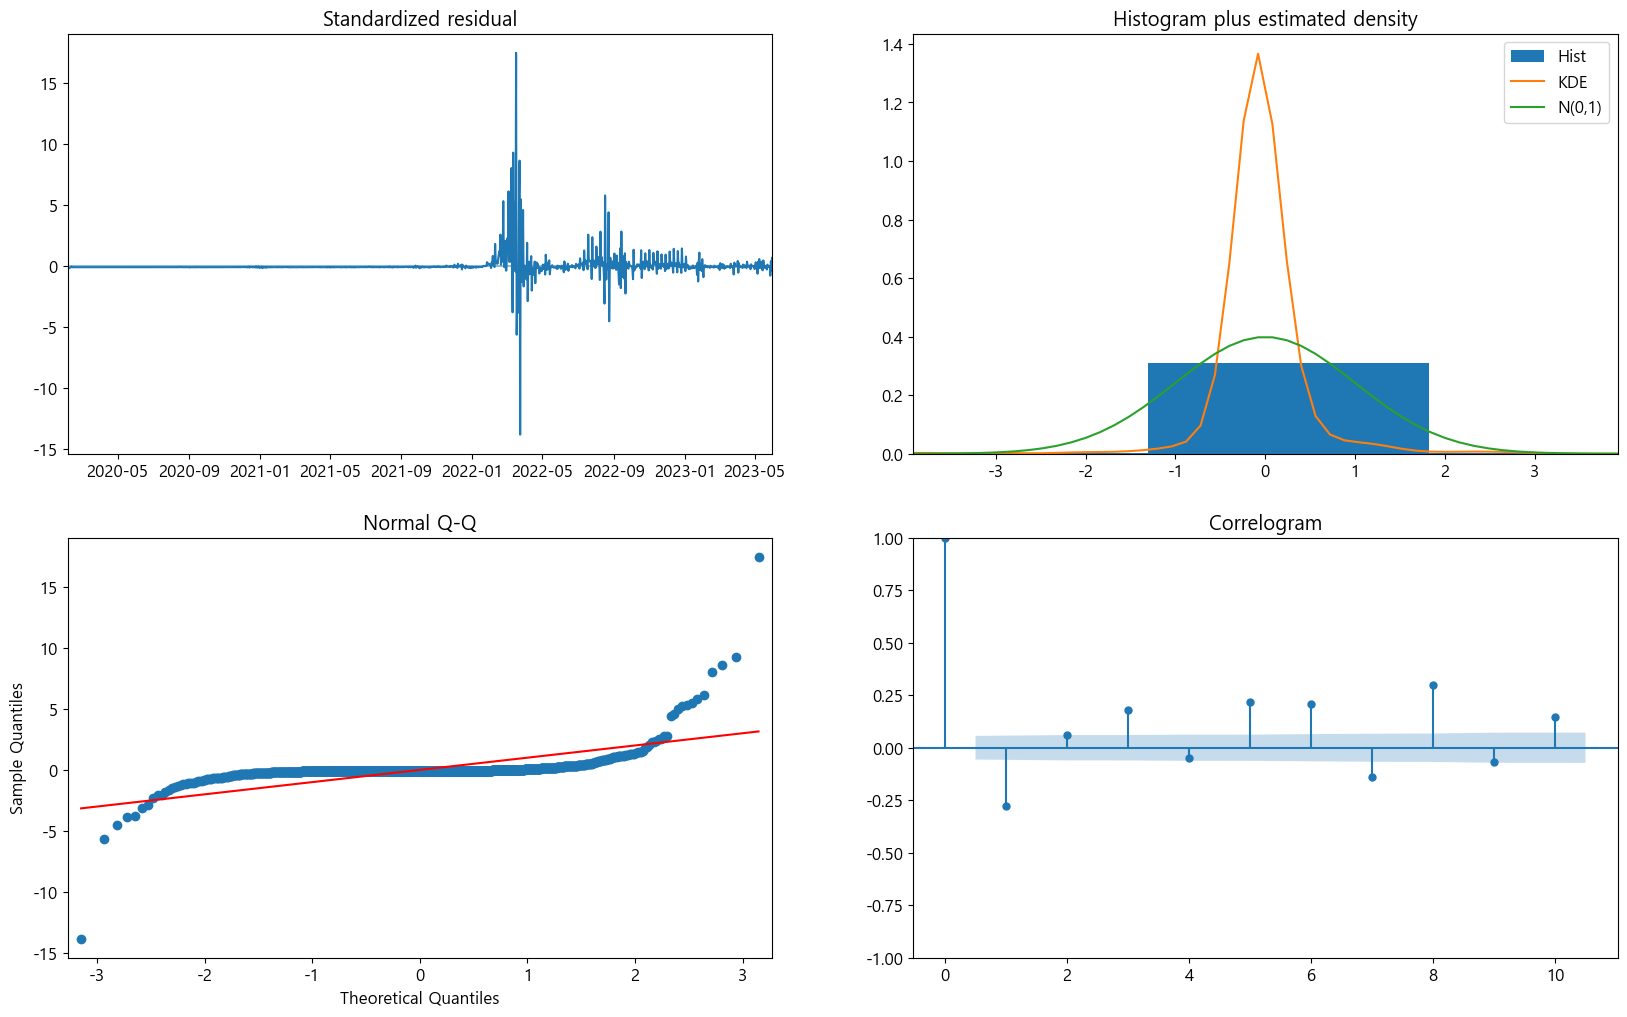

In [19]:
model.plot_diagnostics(figsize=(20, 12))
plt.show()

In [20]:
fv = model.fittedvalues()
fv.head()

2020-02-05    4973.163027
2020-02-06    1006.820088
2020-02-07     931.226825
2020-02-08     836.444900
2020-02-09     719.826046
Freq: D, dtype: float64

In [21]:
fc = model.predict(n_periods=30)
fc.head()

2023-06-01    5161.765132
2023-06-02    4859.508476
2023-06-03    4650.856230
2023-06-04    2639.631671
2023-06-05    2578.946717
Freq: D, dtype: float64

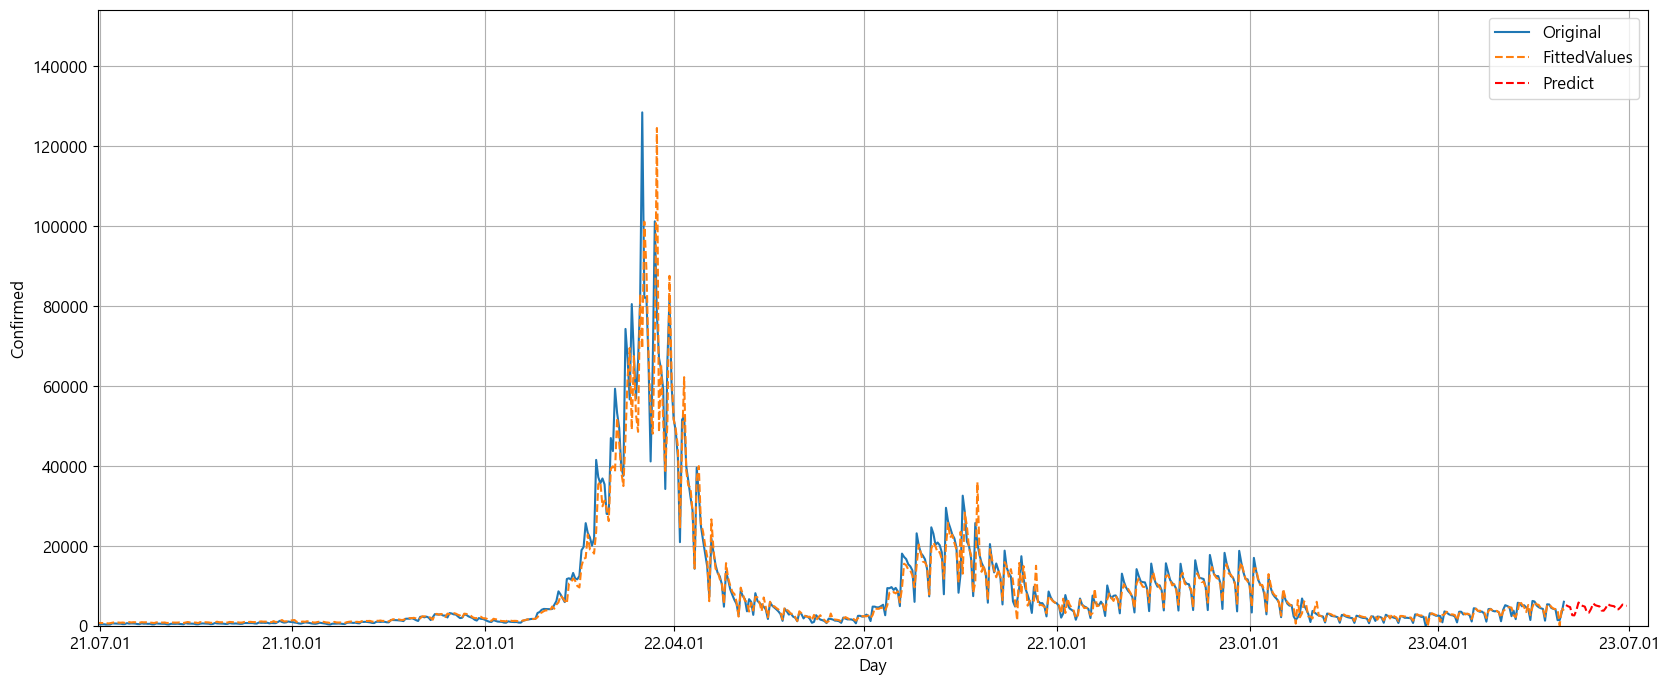

In [22]:
plt.figure(figsize=(20,8))

# 원본 데이터
sb.lineplot(data=df3, x=df3.index, y='confirmed', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 뒤 30% + 10단계에 대한 예측 데이터
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

last = df3.index.max()
xmin = last-timedelta(days=700)
xmax = last+timedelta(days=30+10)
ymax = df3['confirmed'][xmin:xmax].max()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()